## Multiple Linear Regression Project - Predicting SF Apartment Rental Prices


Below please find my first foray into creating a multiple linear regression model! This model aims to predict the 'price' column in a dataset on SF Apartment rentals. The dataset and detailed guidance was provided by Maven Analytics https://mavenanalytics.io/ in the course "Data Science in Python: Regression."

#### Goals for the project

- Improve my EDA skills in Python.
- Learn how to engineer new features in a dataset.
- Understand how a multiple linear regression model works and what the numbers in the summary actually mean.

### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

## The Linear Regression Model 

#### 1. Import appropriate libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

#### 2. Exploratory Data Analysis

- Some preliminary EDA shows that there are 989 datapoints, and 9 variables.
- Average price of an apartment is $3595, and average square footage is 976 square feet.
- Square footage is most strongly correlated with price, with a correlation coefficient of .84.
- There are a handful of extreme outliers in price and square footage.


In [2]:
#to get a sense of the data I will go through some general summary functions 

rentals_df = pd.read_csv("sf_clean.csv") 
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


In [3]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


In [4]:
rentals_df.describe()

,price,sqft,beds,bath,hood_district
count,989.000000,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293,7.052578
std,1546.222670,474.629798,1.076710,0.562714,2.404716
min,750.000000,150.000000,0.000000,1.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000,6.000000
50%,3300.000000,900.000000,2.000000,1.000000,8.000000
75%,4242.000000,1200.000000,2.000000,2.000000,9.000000
max,19000.000000,3500.000000,6.000000,4.000000,10.000000


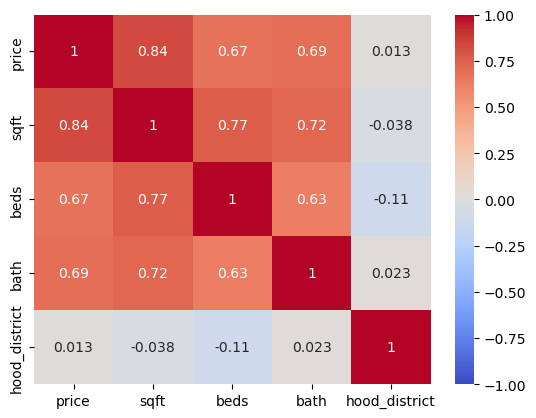

In [5]:
# a correlation heatmap shows square footage is most strongly correlated with price

sns.heatmap(
    rentals_df.corr(numeric_only=True), 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    annot=True
);

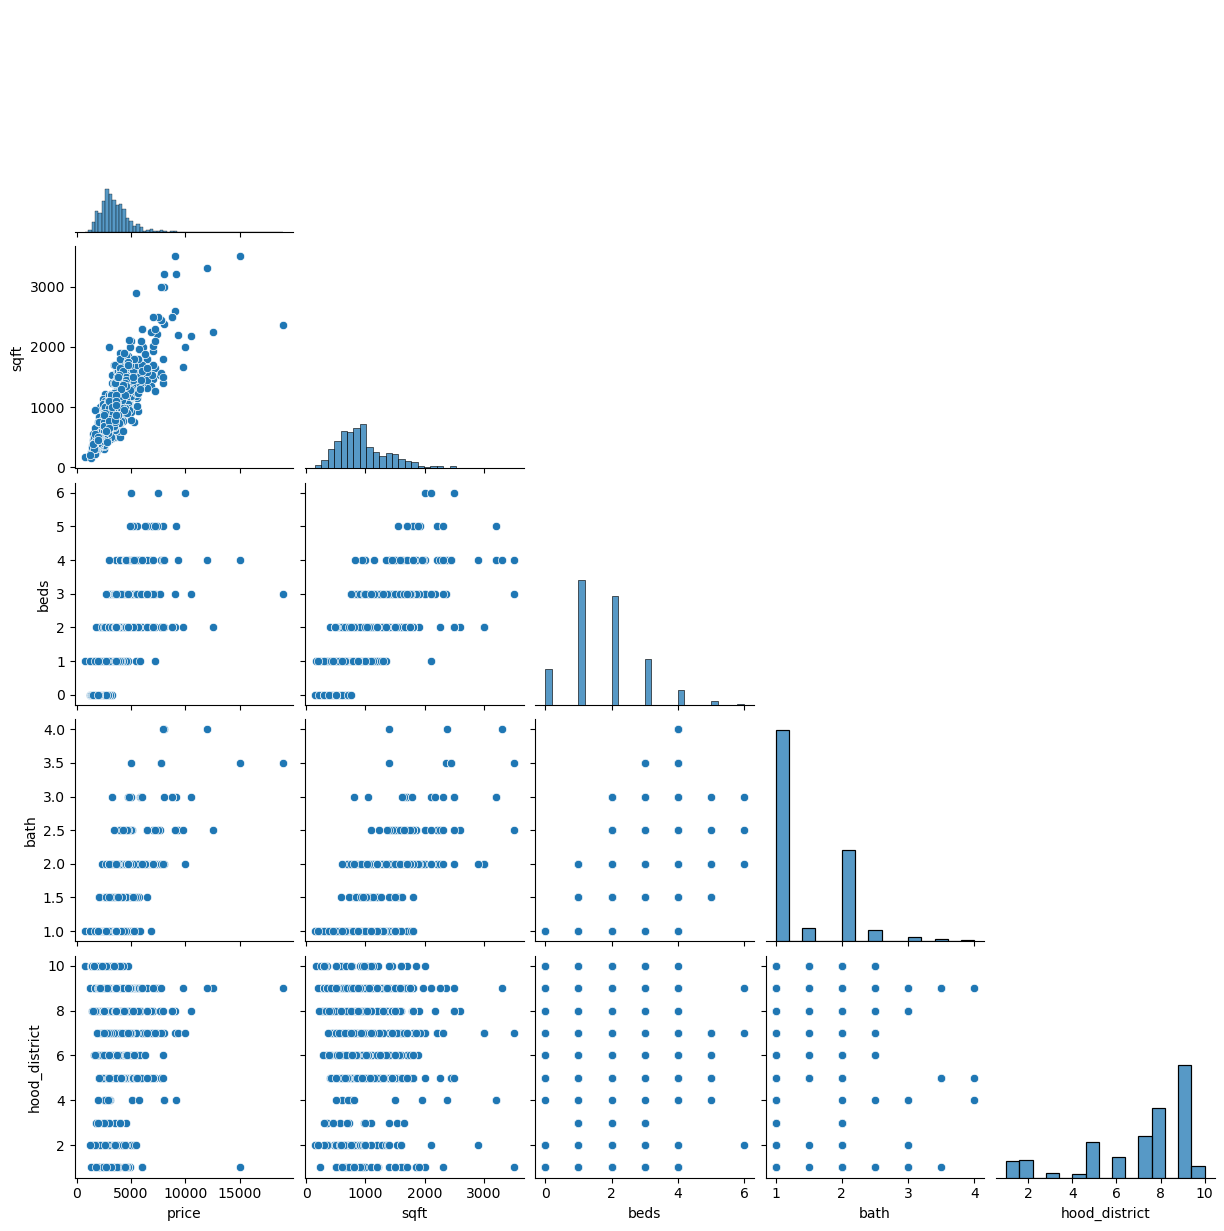

In [6]:
sns.pairplot(rentals_df, corner = True)

<Axes: xlabel='price', ylabel='Count'>

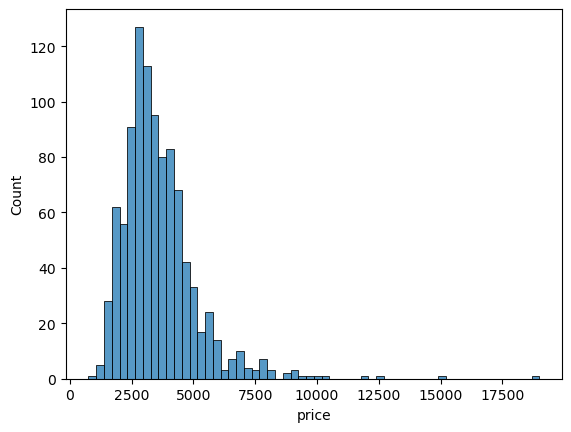

In [7]:
#A histogram of price shows that there are about 4 potential outliers; only 4 data points are above $1100.

sns.histplot(rentals_df.price)

In [8]:
#Isolating the outliers shows that 3 of these are in neighborhood 9 and 1 is in neighborhood, sq ftage of all properties is between 2250 - 3500.
#Since their price is so much greater than the rest of our data, I will experiment with removing these from our dataset.


rentals_df.loc[rentals_df.price>11000]

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
11,15000,3500.0,4.0,3.5,(a) in-unit,(d) no pets,(a) single,(b) protected,1.0
253,19000,2358.0,3.0,3.5,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0
602,12500,2250.0,2.0,2.5,(a) in-unit,(a) both,(c) multi,(a) valet,9.0
927,12000,3300.0,4.0,4.0,(a) in-unit,(a) both,(c) multi,(b) protected,9.0


<Axes: xlabel='sqft', ylabel='Count'>

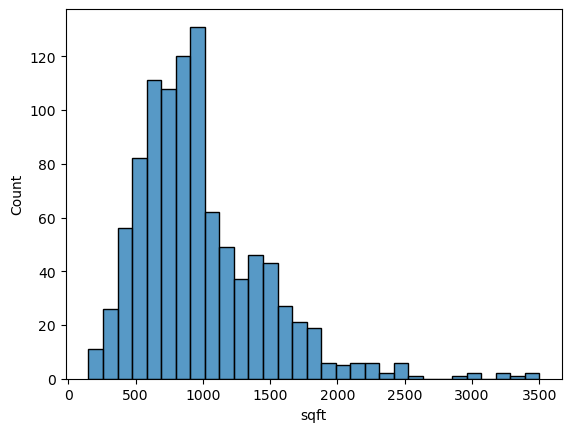

In [9]:
# I will first get a general sense of how the square footage data is distributed.

sns.histplot(rentals_df.sqft)

#### 3. Creating a modified dataframe based on preliminary EDA

In [10]:
# I will create Create a new data frame taking out extreme outliers

rentals_df = rentals_df[rentals_df.price <11000]
rentals_df = rentals_df[rentals_df.sqft <2700]

#### 4. Feature engineering

In [11]:
# I will create additional features from the data by using get_dummies to create new features for the laundry, pets and type columns

pd.get_dummies(rentals_df, drop_first = True, dtype = int)

,price,sqft,beds,bath,hood_district,laundry_(b) on-site,laundry_(c) no laundry,pets_(b) dogs,pets_(c) cats,pets_(d) no pets,housing_type_(b) double,housing_type_(c) multi,parking_(b) protected,parking_(c) off-street,parking_(d) no parking
0,6800,1600.0,2.0,2.0,7.0,0,0,0,0,1,0,1,1,0,0
1,3500,550.0,1.0,1.0,7.0,0,0,0,0,0,0,1,1,0,0
2,5100,1300.0,2.0,1.0,7.0,0,0,0,0,0,0,1,0,0,1
4,3100,561.0,1.0,1.0,7.0,0,1,0,0,0,0,1,0,0,1
5,3800,800.0,2.0,1.0,9.0,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,3595,1200.0,2.0,1.0,9.0,1,0,0,1,0,0,1,0,0,1
985,4695,1700.0,3.0,2.0,7.0,0,0,0,0,1,0,1,0,0,1
986,1950,450.0,1.0,1.0,3.0,0,1,0,0,1,0,0,0,1,0
987,3600,1100.0,3.0,1.0,8.0,0,0,0,0,1,0,1,0,0,1


In [12]:
#engineer features based on neighborhoods. This code was taken directly from the Maven Analytics guided project.

district_map = {
    1.0: "west",
    2.0: "southwest",
    3.0: "southwest",
    4.0: "central",
    5.0: "central",
    6.0: "central",
    7.0: "marina",
    8.0: "north beach",
    9.0: "FiDi/SOMA",
    10.0: "southwest"
    
}

In [13]:
#new dataframe

eng_df = rentals_df.assign(hood_district = rentals_df["hood_district"].map(district_map))


In [14]:
pd.get_dummies(eng_df, drop_first=True, dtype = int)

eng_df = pd.get_dummies(eng_df, drop_first=True, dtype = int)

eng_df

,price,sqft,beds,bath,laundry_(b) on-site,laundry_(c) no laundry,pets_(b) dogs,pets_(c) cats,pets_(d) no pets,housing_type_(b) double,housing_type_(c) multi,parking_(b) protected,parking_(c) off-street,parking_(d) no parking,hood_district_central,hood_district_marina,hood_district_north beach,hood_district_southwest,hood_district_west
0,6800,1600.0,2.0,2.0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0
1,3500,550.0,1.0,1.0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
2,5100,1300.0,2.0,1.0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
4,3100,561.0,1.0,1.0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0
5,3800,800.0,2.0,1.0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,3595,1200.0,2.0,1.0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0
985,4695,1700.0,3.0,2.0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0
986,1950,450.0,1.0,1.0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
987,3600,1100.0,3.0,1.0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0


#### 5. Data Splitting

In [15]:
# We are now ready to split the data into testing and training data for our model

from sklearn.model_selection import train_test_split

y = eng_df["price"]

X = sm.add_constant(eng_df.drop(["price"], axis=1))

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

#### 6. Model Fitting & Validation Scoring

In [20]:
#Cross validation - please note this code was taken from the Maven Analytics guided project on linear regression

def cross_val(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)
    # Create a list to store validation scores for each fold

    training_r2s = []
    training_mae = []
    validation_r2s = []
    validation_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        training_r2s.append(r2(y_train, model.predict(X_train)))
        training_mae.append(mae(y_train, model.predict(X_train)))
        validation_r2s.append(r2(y_val, model.predict(X_val),))
        validation_mae.append(mae(y_val, model.predict(X_val),))
        
        
    print(f"All Training R2s: {[round(x, 3) for x in training_r2s]}")
    print(f"Training R2s: {round(np.mean(training_r2s), 3)} +- {round(np.std(training_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in training_mae]}")
    print(f"Training MAEs: {round(np.mean(training_mae), 3)} +- {round(np.std(training_mae), 3)}")    
        
    print(f"All Validation R2s: {[round(x, 3) for x in validation_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(validation_r2s), 3)} +- {round(np.std(validation_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in validation_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(validation_mae), 3)} +- {round(np.std(validation_mae), 3)}")
    
    return model
    
model = cross_val(X, y, 5)

All Training R2s: [0.771, 0.782, 0.78, 0.781, 0.776]
Training R2s: 0.778 +- 0.004
Training MAEs: [457.691, 441.351, 448.866, 450.937, 453.135]
Training MAEs: 450.396 +- 5.388
All Validation R2s: [0.794, 0.746, 0.749, 0.742, 0.772]
Cross Val R2s: 0.761 +- 0.019
All Validation MAEs: [444.791, 484.118, 485.087, 461.61, 439.843]
Cross Val MAEs: 463.09 +- 18.992


In [21]:
# Model p-values: a few features have > .05

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     116.9
Date:                Tue, 16 Jul 2024   Prob (F-statistic):          1.03e-183
Time:                        20:59:32   Log-Likelihood:                -4925.3
No. Observations:                 627   AIC:                             9889.
Df Residuals:                     608   BIC:                             9973.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2030.2722    228.554      8.883      0.000    1581.420    2479.124
sqft                          1.6966      0.112     15.122      0.000       1.476       1.917
beds                        196.6803     41.767      4.709      0.000     114.656     278.705
bath                        293.8575     67.061      4.382      0.000     162.158     425.557
laundry_(b) on-site        -286.9448     64.170     -4.472      0.000    -412.966    -160.924
laundry_(c) no laundry     -255.7622     87.535     -2.922      0.004    -427.670     -83.854
pets_(b) dogs               656.2273    196.605      3.338      0.001     270.120    1042.335
pets_(c) cats               -39.8194     96.156     -0.414      0.679    -228.658     149.019
pets_(d) no pets             -4.4510     57.388     -0.078      0.938    -117.153     108.251
housing_type_(b) double     230.1747    321.273      0.716      0.474    -400.764     861.114
housing_type_(c) multi       22.8947    142.991      0.160      0.873    -257.922     303.712
parking_(b) protected      -742.4549    147.237     -5.043      0.000   -1031.610    -453.300
parking_(c) off-street     -669.2996    206.084     -3.248      0.001   -1074.023    -264.576
parking_(d) no parking     -923.1860    152.343     -6.060      0.000   -1222.368    -624.004
hood_district_central       219.1386     79.569      2.754      0.006      62.875     375.402
hood_district_marina        419.8007     86.013      4.881      0.000     250.882     588.719
hood_district_north beach    64.1127     74.730      0.858      0.391     -82.647     210.873
hood_district_southwest    -410.9811    103.951     -3.954      0.000    -615.128    -206.834
hood_district_west         -171.4791    135.372     -1.267      0.206    -437.332      94.374
==============================================================================
Omnibus:                      144.285   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              544.341
Skew:                           1.023   Prob(JB):                    6.28e-119
Kurtosis:                       7.080   Cond. No.                     1.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 7. Final Model Fit & Test Scoring

In [22]:
final_model = sm.OLS(y, X).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     147.4
Date:                Tue, 16 Jul 2024   Prob (F-statistic):          4.67e-234
Time:                        20:59:39   Log-Likelihood:                -6161.6
No. Observations:                 783   AIC:                         1.236e+04
Df Residuals:                     764   BIC:                         1.245e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2089.7223    210.081      9.947      0.000    1677.318    2502.126
sqft                          1.6810      0.101     16.659      0.000       1.483       1.879
beds                        216.2804     36.974      5.850      0.000     143.698     288.863
bath                        311.3165     62.052      5.017      0.000     189.504     433.129
laundry_(b) on-site        -271.8598     57.518     -4.727      0.000    -384.771    -158.949
laundry_(c) no laundry     -241.9163     78.132     -3.096      0.002    -395.295     -88.538
pets_(b) dogs               459.1023    176.146      2.606      0.009     113.315     804.889
pets_(c) cats               -46.0273     87.371     -0.527      0.598    -217.543     125.489
pets_(d) no pets             -2.6316     51.233     -0.051      0.959    -103.207      97.943
housing_type_(b) double      19.7999    275.219      0.072      0.943    -520.476     560.075
housing_type_(c) multi      -63.4551    128.479     -0.494      0.622    -315.669     188.759
parking_(b) protected      -775.9817    138.139     -5.617      0.000   -1047.159    -504.804
parking_(c) off-street     -616.9370    187.320     -3.293      0.001    -984.660    -249.214
parking_(d) no parking     -946.6504    142.409     -6.647      0.000   -1226.209    -667.092
hood_district_central       235.4546     71.236      3.305      0.001      95.613     375.296
hood_district_marina        445.4185     80.249      5.550      0.000     287.885     602.952
hood_district_north beach   111.0450     67.113      1.655      0.098     -20.702     242.792
hood_district_southwest    -451.4488     91.840     -4.916      0.000    -631.738    -271.159
hood_district_west         -162.3446    116.871     -1.389      0.165    -391.772      67.082
==============================================================================
Omnibus:                      219.199   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1074.570
Skew:                           1.188   Prob(JB):                    4.57e-234
Kurtosis:                       8.224   Cond. No.                     1.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
print(f"Test R2: {r2(y_test, model.predict(X_test))} ")
print(f"Test MAE: {mae(y_test, model.predict(X_test))}")

Test R2: 0.782544130370781 
Test MAE: 436.44204776705163
